In [ ]:
%pip install drfp
%pip install kneed
%pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from drfp import DrfpEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv('датасет 4000 реакций (с первых 100 страниц SF).csv', delimiter=';')

In [ ]:
#отделяем датасет, где известны все смайлзы
for idx in df.index:
  if 'None' in df.loc[idx, 'reactants_smiles'] or 'None' in df.loc[idx, 'products_smiles'] or '|' in df.loc[idx, 'reactants_smiles']:
    df.drop(labels=idx, inplace=True)
df = df.reset_index(drop=True)
df.head(30)

,reaction_id,stages_number,yield_value,reactants,products,title,authors,bibliography,other_conditions_1,temperature,...,catalysts_1_2,solvents_1,other_conditions_2,reagents_2,catalysts_2,solvents_2,solvents_1_2,reactants_smiles,products_smiles,cluster
0,31-614-CAS-26539186,1,100.0,110-54-3,74-82-8,Dehydrocyclization of n-hexane over heteropoly...,"Eid, Abdellah",Advances in Chemical Engineering and Science (...,400 °C,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCC,C,5
1,31-614-CAS-28519743,1,96.0,110-54-3,74-82-8,Hierarchical H-ZSM-5-supported cobalt for the ...,"Sartipi, Sina","Journal of Catalysis (2013), 305, 179-190","15 bar, 493 K",220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCC,C,5
2,31-614-CAS-30341229,2,93.0,110-54-3,74-82-8,Different Catalytic Reactions of n-Hexane and ...,"Al-Kharafi, F.","Catalysis Letters (2008), 123(3-4), 269-275","24 h, 873 K",600.0,...,NaN,NaN,873 K,Hydrogen,NaN,NaN,NaN,CCCCCC,C,5
3,31-614-CAS-30602615,1,100.0,112-80-1,74-82-8,Preparation method of methane by fatty acid hy...,"Zhang, Jing","China, CN109776248 A 2019-05-21","10 h, rt → 360 °C",192.5,...,NaN,Water,NaN,NaN,NaN,NaN,NaN,CCCCCCCC/C=C/CCCCCCCC(O)=O,C,4
4,31-614-CAS-28368873,1,100.0,124-38-9,74-82-8,Accessing Two-Coordinate ZnII Organocations by...,"Specklin, David","Chemistry - A European Journal (2017), 23(63),...","1.5 bar, rt",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C=O,C,5
5,31-614-CAS-29967082,1,87.0,124-38-9,74-82-8,Characteristics of adapted hydrogenotrophic co...,"Rachbauer, Lydia","Science of the Total Environment (2017), 595, ...","4 d, 38 °C",38.0,...,NaN,Water,NaN,NaN,NaN,NaN,NaN,O=C=O,C,5
6,31-614-CAS-30730219,1,82.0,124-38-9,74-82-8,Selective Reduction of CO2 to CH4 by Tandem Hy...,"Chen, Jiawei",Journal of the American Chemical Society (2016...,"5 h, 100 °C",100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C=O,C,5
7,31-614-CAS-29824211,1,100.0,144-62-7,74-84-0,Catalytic hydrosilylation of oxalic acid: chem...,"Feghali, Elias","Catalysis Science & Technology (2014), 4(8), 2...",rt,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OC(=O)C(O)=O,CC,7
8,31-614-CAS-25741386,1,100.0,15194-58-8.2050-77-3,1120-21-4,Reactions of new organocuprates. 2. Substituti...,"Ashby, Eugene C.","Journal of Organic Chemistry (1977), 42(17), 2...",NaN,NaN,...,NaN,Tetrahydrofuran,NaN,NaN,NaN,NaN,NaN,[CH3-] ; CCCCCCCCCCI,CCCCCCCCCCC,5
9,31-614-CAS-27974066,1,100.0,57-11-4.57-10-3,74-82-8,Preparation method of methane by fatty acid hy...,"Zhang, Jing","China, CN109776248 A 2019-05-21","5 h, rt → 400 °C",212.5,...,NaN,Water,NaN,NaN,NaN,NaN,NaN,CCCCCCCCCCCCCCCCCC(O)=O ; CCCCCCCCCCCCCCCC(O)=O,C,7


In [ ]:
#соединяем смайлзы реагентов и продуктов в общий смайлз реакции
rxn_smiles=[]
for idx in df.index:
  reactants = df.loc[idx, 'reactants_smiles'].split(' ; ')
  reactants = '.'.join(reactants)
  products = df.loc[idx, 'products_smiles'].split(' ; ')
  products = '.'.join(products)
  rxn = reactants + '>>' + products
  rxn_smiles.append(rxn)

In [ ]:
#перевод в фингерпринты

list_fps_reaction = []
for i in rxn_smiles:
  fp = DrfpEncoder.encode(i, n_folded_length=512)
  list_fps_reaction.append(fp)

In [ ]:
print(len(list_fps_reaction))

2768


In [ ]:
X = np.array(list_fps_reaction)
X = X.reshape(2768, 512)
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
def elbow(scores, n): #график score от k
  plt.figure(figsize=(15,4))
  plt.title("The elbow method for determining number of clusters\n",fontsize=16)
  plt.scatter(x=[i for i in range(2,n)],y=scores,s=150,edgecolor='k')
  plt.grid(True)
  plt.xlabel("Number of clusters",fontsize=14)
  plt.ylabel("K-means score",fontsize=15)
  plt.xticks([i for i in range(2,n)],fontsize=14)
  plt.yticks(fontsize=15)
  plt.show()

In [ ]:
def sil_plot(sil, n): #график силуэта от k
  plt.figure(figsize=(15,4))
  plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
  plt.scatter(x=[i for i in range(2,n)],y=sil,s=150,edgecolor='k')
  plt.grid(True)
  plt.xlabel("Number of clusters",fontsize=14)
  plt.ylabel("Silhouette score",fontsize=15)
  plt.xticks([i for i in range(2,n)],fontsize=14)
  plt.yticks(fontsize=15)
  plt.show()

In [ ]:
km_silhouette = []
km_scores= []
m = 21
for n in range(2, m):
  kmeans = KMeans(n_clusters=n, init='random', algorithm='elkan', n_init=10, random_state=100).fit(X)
  preds = kmeans.predict(X)
  score = kmeans.score(X)
  silhouette = silhouette_score(X,preds)
  km_scores.append(-score)
  km_silhouette.append(silhouette)

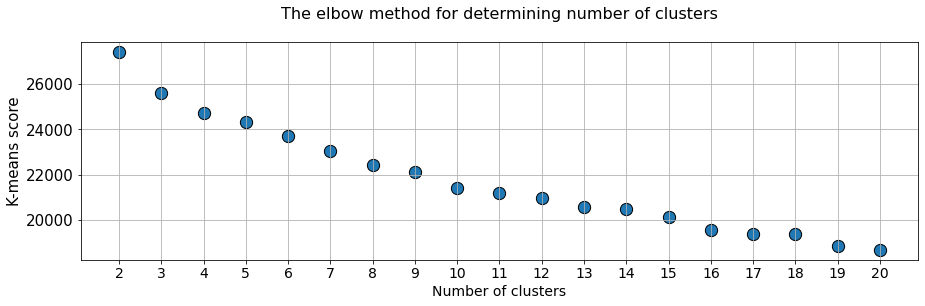

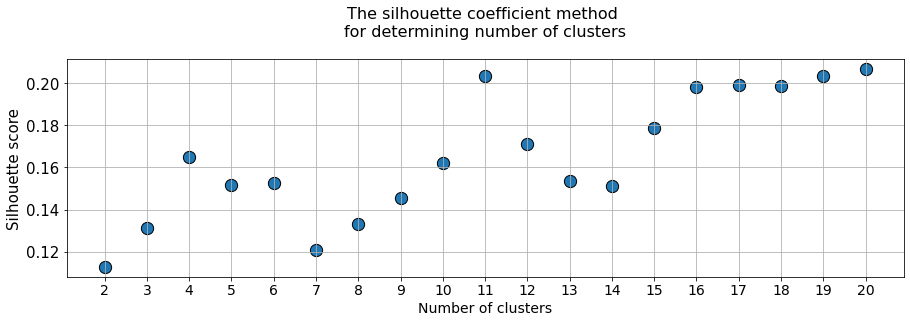

In [ ]:
elbow(km_scores, m)
sil_plot(km_silhouette, m)

In [ ]:
kmeans = KMeans(n_clusters=11, init='random', algorithm='elkan', n_init=10, random_state=100).fit(X)
df['cluster']=kmeans.predict(X)
df['fp']=list_fps_reaction
df1 = df[df['cluster']==3]
df1 = df1.drop_duplicates(subset=['reactants_smiles', 'products_smiles'], keep='first')
df1[['reaction_id', 'reactants_smiles', 'products_smiles', 'cluster']].head(50)

,reaction_id,reactants_smiles,products_smiles,cluster,fp
3,31-614-CAS-30602615,CCCCCCCC/C=C/CCCCCCCC(O)=O,C,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,..."
9,31-614-CAS-27974066,CCCCCCCCCCCCCCCCCC(O)=O ; CCCCCCCCCCCCCCCC(O)=O,C,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,..."
223,31-614-CAS-25351009,[C-]#[O+] ; C,CC(O)=O,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
267,31-614-CAS-29193642,[C-]#[O+] ; CC,CCC(O)=O,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
317,31-614-CAS-24390141,CCC(O)=O,C,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
366,31-614-CAS-27866829,[C-]#[O+] ; OCc1ccccc1 ; CC,CCC(=O)OCc1ccccc1,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
369,31-614-CAS-27506948,OC(=O)CC(O)(CC(O)=O)C(O)=O ; NC(N)=O,[C],3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
376,31-614-CAS-27488428,NCCN ; OC(=O)CC(O)(CC(O)=O)C(O)=O,[C],3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
378,31-614-CAS-26707577,COC1=C(OC)C(=O)C(=CC1=O)C ; NCCN ; NC(CCCN=C(N...,[C],3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
390,31-614-CAS-28639298,NCCN ; ClC1=C(Cl)C(=O)C(=C(C#N)C1=O)C#N ; NC(C...,[C],3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,..."


Text(0, 0.5, 'Distance')

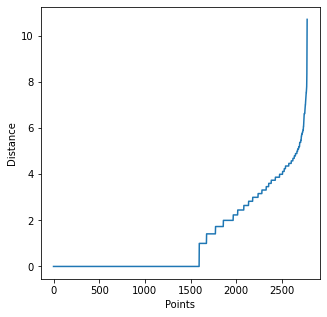

In [ ]:
from sklearn.neighbors import NearestNeighbors
#k=ln(n) where n is the number of points to be clustered
nearest_neighbors = NearestNeighbors(n_neighbors=8)
neighbors = nearest_neighbors.fit(X)

distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,7], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

3.7416573867739413


<Figure size 360x360 with 0 Axes>

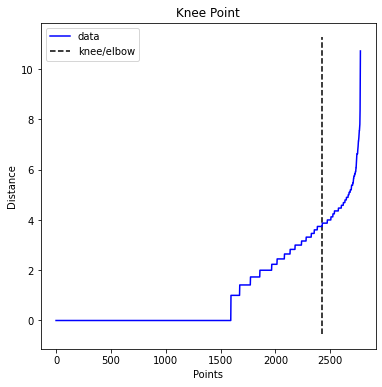

In [ ]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
a = distances[knee.knee]
print(a)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import v_measure_score
from rdkit.Chem import DataStructs
import numpy

dbs = DBSCAN(eps=a, min_samples=8, metric='euclodean').fit(X)
labels = dbs.labels_
#silhouette = silhouette_score(X,labels)
#print(silhouette)

N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)
n_noise = list(dbs.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

Estimated no. of clusters: 1
Estimated no. of noise points: 0


In [ ]:
from sklearn.cluster import Birch
from sklearn import metrics
brc = Birch(n_clusters=None, threshold=2)
brc.fit(X)
print(len(set(brc.labels_)))

130


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_


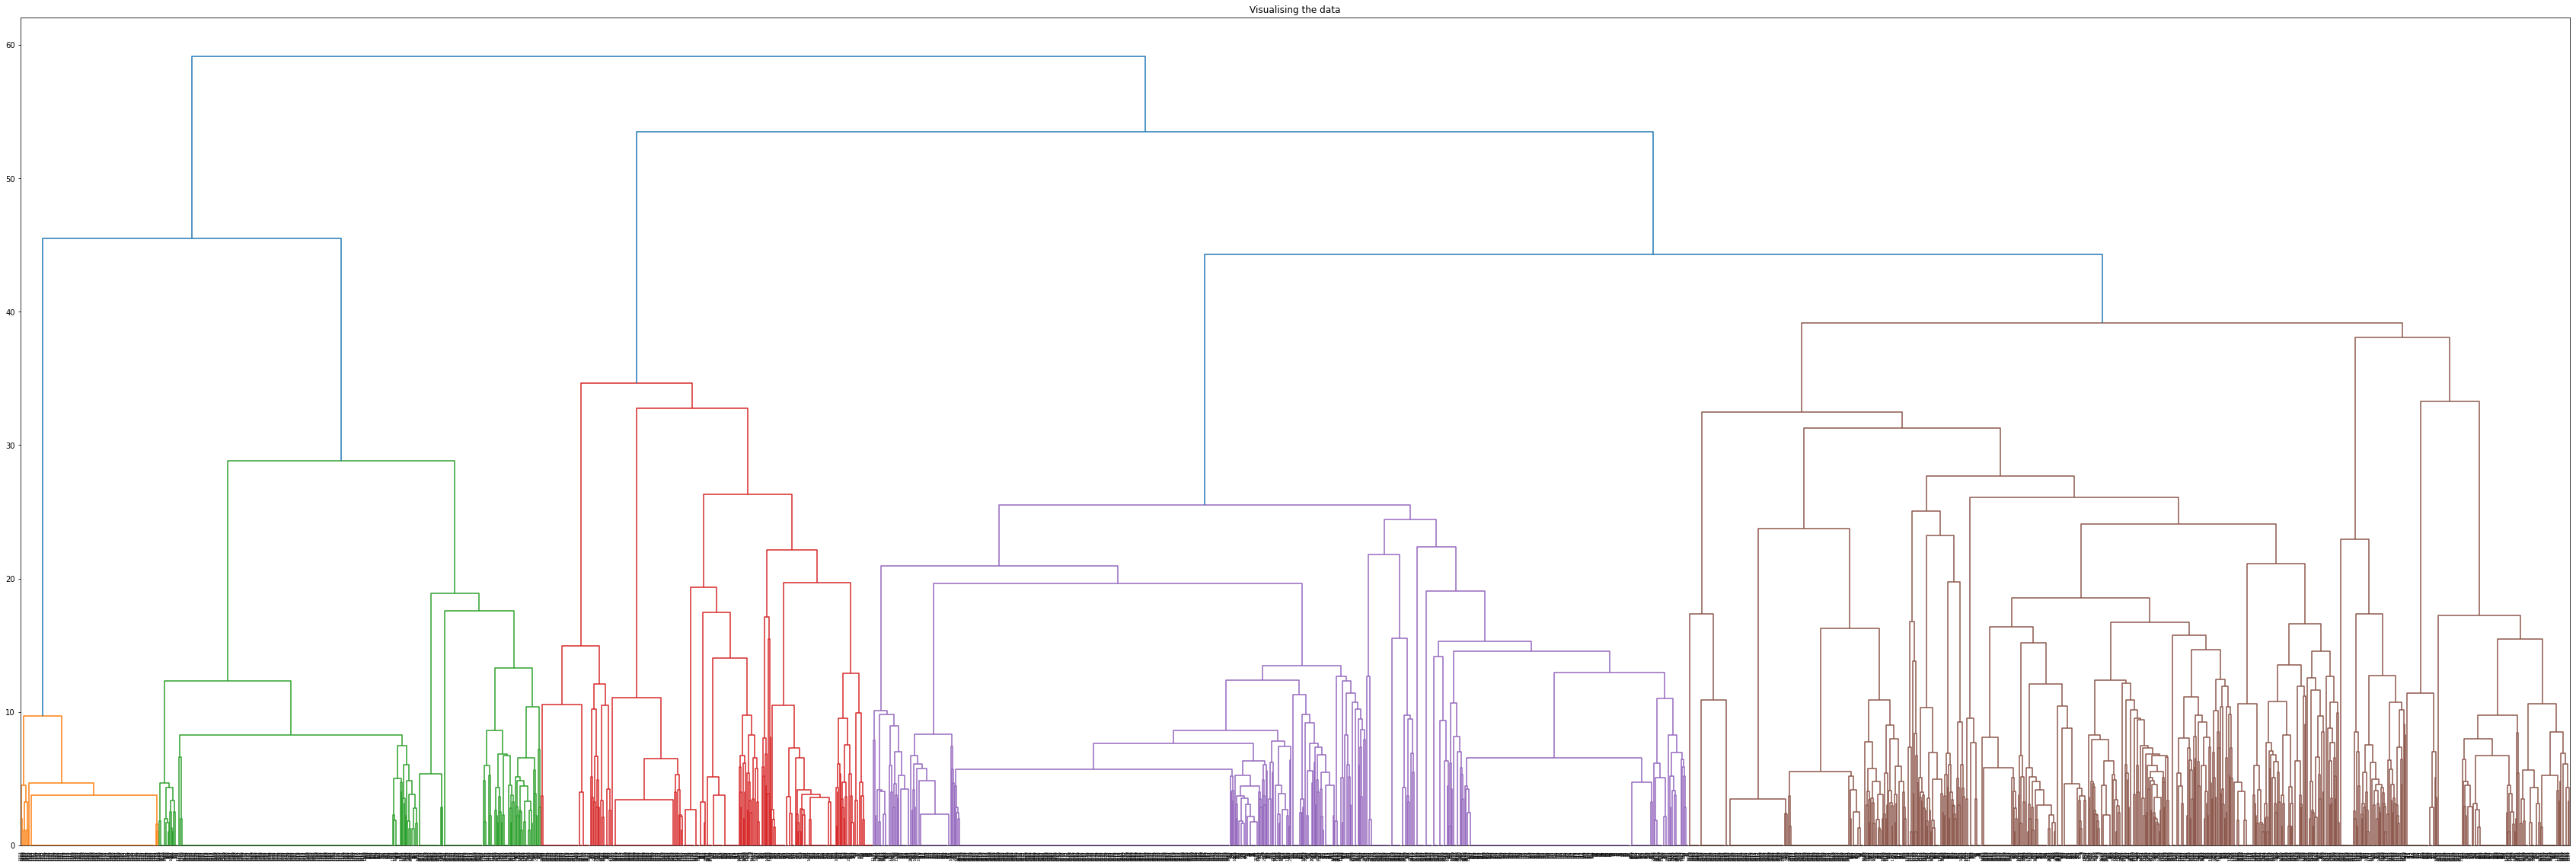

In [ ]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
#ag = AgglomerativeClustering().fit(X)
plt.figure(figsize =(60, 20))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X, method ='ward')))